# Impact d'événements disruptifs sur le marché

On considère 5 évènements disruptifs majeurs :

1. Catastrophe naturelle :
Incendies en Californie - 8 novembre 2018 (début)

2. Evenement sectoriel :
Scandale des opioïdes (Purdue Pharma & Big Pharma) - 25 octobre 2017 (premier procès d'État majeur contre les fabricants d’opioïdes)

3. Evenement entreprise :
Tweet “Funding secured” d’Elon Musk (Tesla) - 7 août 2018 (15h08 ET)

4. Evenement mondial :
Invasion de l’Ukraine par la Russie - 24 février 2022 (début officiel à l’aube)

5. Evenement politique :
Brexit / Référendum UK - 23 juin 2016

On cherche à faire des statistiques descriptives pour mesurer l'impact de ces événements sur le marché.

In [1]:
import pandas as pd

Pour cette section, les seules données requises sont les données Yahoo Finance S&P 500 auxquelles on a ajouté les features.

In [11]:
df = pd.read_csv(r"C:\Users\lloyd\OneDrive\Documents\Projet python\data\dataset_with_feature.csv")

On précise le secteur auquel appartient chaque entreprise

In [ ]:
import requests

url = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"
headers = {"User-Agent": "Mozilla/5.0"}

resp = requests.get(url, headers=headers)
resp.raise_for_status()  # lève une erreur si 4xx/5xx

tables = pd.read_html(resp.text, header=0)
sp500 = tables[0]

sp500 = sp500.rename(columns={"Symbol": "Ticker", "GICS Sector": "Sector"})
sp500['Ticker'] = sp500['Ticker'].str.replace('.', '-', regex=False)

df = df.sort_values(by=['Ticker', 'Date'])

df = df.merge(
    sp500[['Ticker', 'Sector']], 
    on='Ticker', 
    how='left'
)

# code repris de description_2

C:\Users\lloyd\AppData\Local\Temp\ipykernel_18796\2677998947.py:9: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  tables = pd.read_html(resp.text, header=0)


  Ticker             Security                  Sector  \
0    MMM                   3M             Industrials   
1    AOS          A. O. Smith             Industrials   
2    ABT  Abbott Laboratories             Health Care   
3   ABBV               AbbVie             Health Care   
4    ACN            Accenture  Information Technology   

                GICS Sub-Industry    Headquarters Location  Date added  \
0        Industrial Conglomerates    Saint Paul, Minnesota  1957-03-04   
1               Building Products     Milwaukee, Wisconsin  2017-07-26   
2           Health Care Equipment  North Chicago, Illinois  1957-03-04   
3                   Biotechnology  North Chicago, Illinois  2012-12-31   
4  IT Consulting & Other Services          Dublin, Ireland  2011-07-06   

       CIK      Founded  
0    66740         1902  
1    91142         1916  
2     1800         1888  
3  1551152  2013 (1888)  
4  1467373         1989  


I. Incendies en Californie

In [18]:
df['Date']  = pd.to_datetime(df['Date'])
date_event = pd.to_datetime('2018-11-08')

df_event = df[(df['Date'] >= date_event - pd.Timedelta(days=15)) & (df['Date'] <= date_event + pd.Timedelta(days=15))].copy()

La plupart des entreprises sont localisées aux Etats-Unis, on va observer les résultats pour les entreprises nord-américaines et les autres.

In [19]:
non_na_sp500_ticker = [
    'ACN',
    'ALLE',
    'AMCR',
    'AON',
    'APTV',
    'CB',
    'ETN',
    'GRMN',
    'JCI',
    'LIN',
    'LYB',
    'MDT',
    'NXPI',
    'PNR',
    'STX',
    'SW',
    'STE',
    'TEL',
    'TT',
    'WTW'
]

df_na = df_event[~df_event['Ticker'].isin(non_na_sp500_ticker)].copy()
df_non_na = df_event[df_event['Ticker'].isin(non_na_sp500_ticker)].copy()  

1. Returns

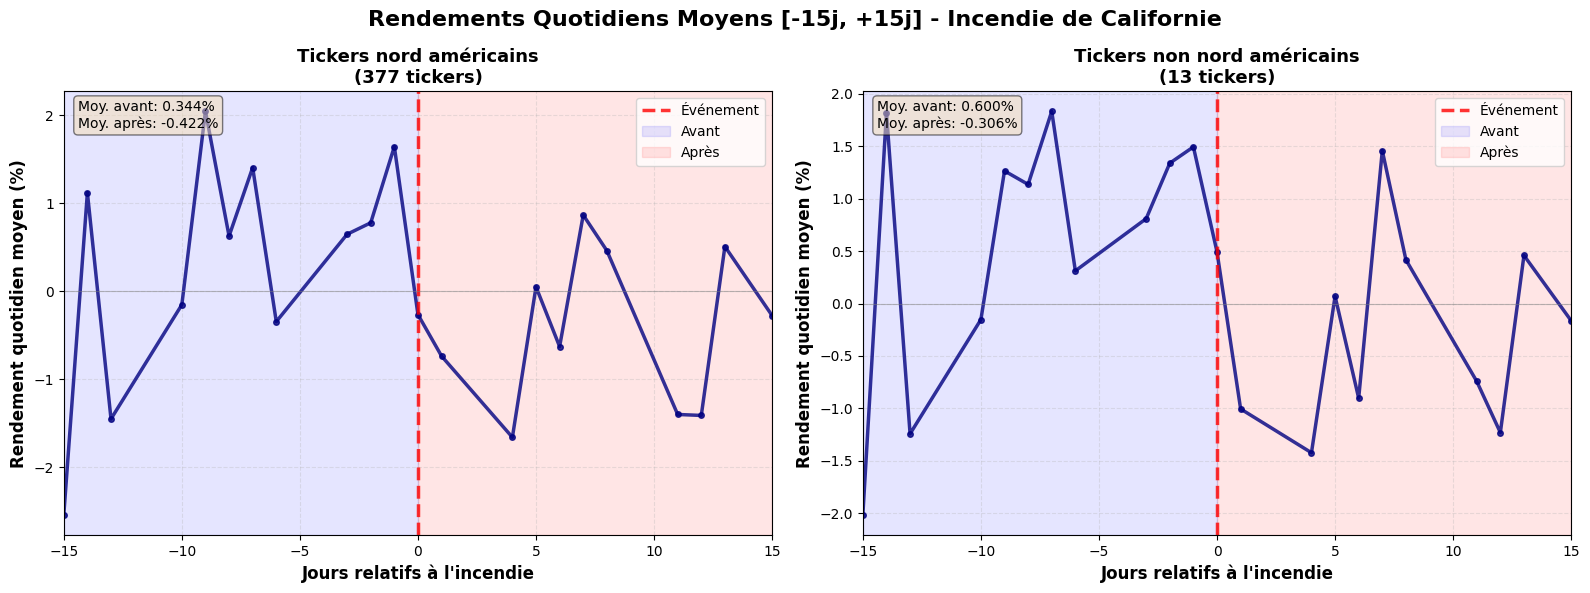

In [27]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Calculer les rendements quotidiens moyens pour chaque groupe
for idx, (df_subset, label, ax) in enumerate([
    (df_na, 'Tickers nord américains', axes[0]),
    (df_non_na, 'Tickers non nord américains', axes[1])
]):
    # Grouper par date et calculer la moyenne des rendements
    daily_avg_returns = df_subset.groupby('Date')['R1J'].mean() * 100
    
    # Créer un index de jours relatifs à l'événement
    dates = daily_avg_returns.index.sort_values()
    days_relative = [(d - date_event).days for d in dates]
    
    # Tracer la courbe
    ax.plot(days_relative, daily_avg_returns.loc[dates].values, 
        linewidth=2.5, color='navy', marker='o', markersize=4, alpha=0.8)
    
    # Ligne verticale pour l'événement
    ax.axvline(x=0, color='red', linestyle='--', linewidth=2.5, 
            label='Événement', alpha=0.8)
    
    # Ligne horizontale à 0
    ax.axhline(y=0, color='gray', linestyle='-', linewidth=0.8, alpha=0.5)
    
    # Zones avant/après colorées
    ax.axvspan(-15, 0, alpha=0.1, color='blue', label='Avant')
    ax.axvspan(0, 15, alpha=0.1, color='red', label='Après')
    
    # Labels et titre
    ax.set_xlabel('Jours relatifs à l\'incendie', fontsize=12, fontweight='bold')
    ax.set_ylabel('Rendement quotidien moyen (%)', fontsize=12, fontweight='bold')
    ax.set_title(f'{label}\n({len(df_subset["Ticker"].unique())} tickers)', 
                fontsize=13, fontweight='bold')
    
    # Grille et légende
    ax.grid(True, alpha=0.3, linestyle='--')
    ax.legend(loc='best', fontsize=10)
    
    # Limites de l'axe X
    ax.set_xlim(-15, 15)
    
    # Ajouter les statistiques sur le graphique
    mean_before = df_subset[df_subset['Date'] < date_event]['R1J'].mean() * 100
    mean_after = df_subset[df_subset['Date'] > date_event]['R1J'].mean() * 100
    
    stats_text = f'Moy. avant: {mean_before:.3f}%\nMoy. après: {mean_after:.3f}%'
    ax.text(0.02, 0.98, stats_text, transform=ax.transAxes,
        fontsize=10, verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# Titre général
fig.suptitle(f'Rendements Quotidiens Moyens [-15j, +15j] - {'Incendie de Californie'}',
            fontsize=16, fontweight='bold', y=0.98)

plt.tight_layout()

2. Volatilité

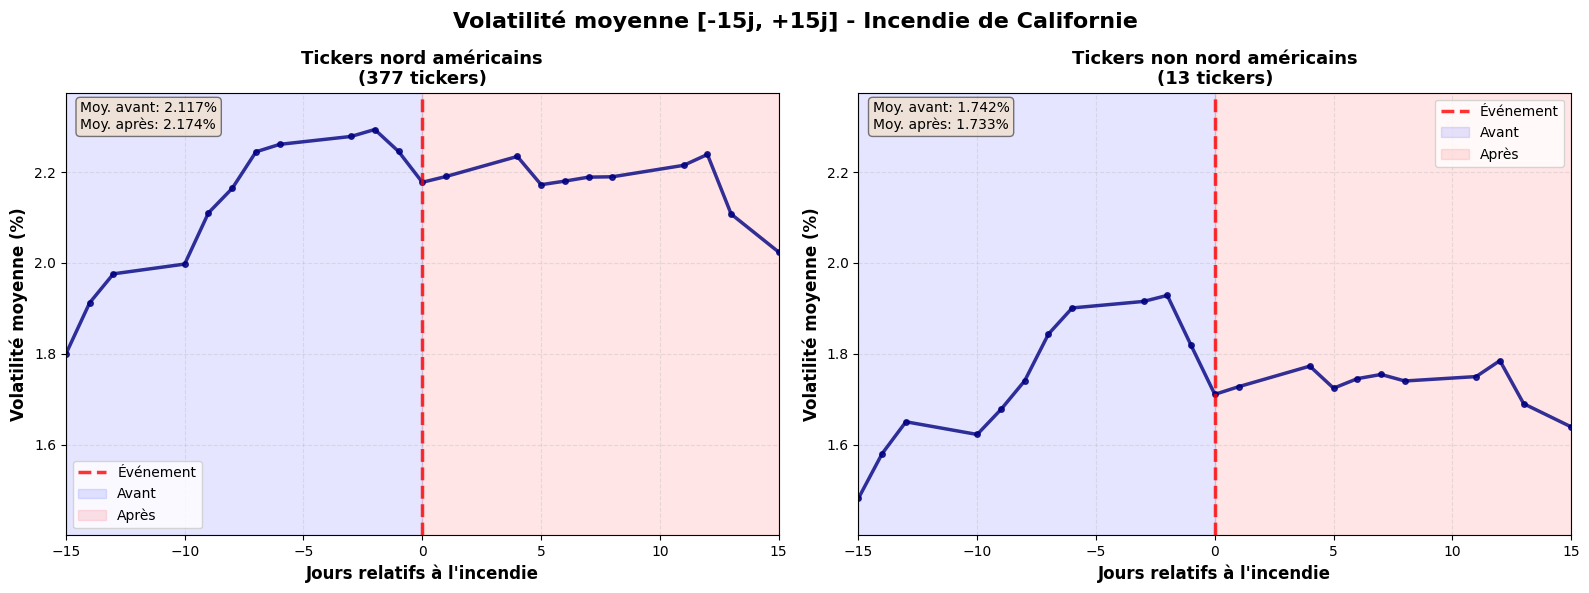

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Stocker les valeurs min/max pour synchroniser les échelles
all_values = []

# Calculer les rendements quotidiens moyens pour chaque groupe
for idx, (df_subset, label, ax) in enumerate([
    (df_na, 'Tickers nord américains', axes[0]),
    (df_non_na, 'Tickers non nord américains', axes[1])
]):
    # Grouper par date et calculer la moyenne des rendements
    daily_avg_volatility = df_subset.groupby('Date')['Volatilite 20J'].mean() * 100
    
    # Stocker les valeurs pour calculer l'échelle globale
    all_values.extend(daily_avg_volatility.values)
    
    # Créer un index de jours relatifs à l'événement
    dates = daily_avg_volatility.index.sort_values()
    days_relative = [(d - date_event).days for d in dates]
    
    # Tracer la courbe
    ax.plot(days_relative, daily_avg_volatility.loc[dates].values, 
        linewidth=2.5, color='navy', marker='o', markersize=4, alpha=0.8)
    
    # Ligne verticale pour l'événement
    ax.axvline(x=0, color='red', linestyle='--', linewidth=2.5, 
            label='Événement', alpha=0.8)
    
    # Ligne horizontale à 0 (retirée car volume ne peut être négative)
    # ax.axhline(y=0, color='gray', linestyle='-', linewidth=0.8, alpha=0.5)
    
    # Zones avant/après colorées
    ax.axvspan(-15, 0, alpha=0.1, color='blue', label='Avant')
    ax.axvspan(0, 15, alpha=0.1, color='red', label='Après')
    
    # Labels et titre
    ax.set_xlabel('Jours relatifs à l\'incendie', fontsize=12, fontweight='bold')
    ax.set_ylabel('Volatilité moyenne (%)', fontsize=12, fontweight='bold')
    ax.set_title(f'{label}\n({len(df_subset["Ticker"].unique())} tickers)', 
                fontsize=13, fontweight='bold')
    
    # Grille et légende
    ax.grid(True, alpha=0.3, linestyle='--')
    ax.legend(loc='best', fontsize=10)
    
    # Limites de l'axe X
    ax.set_xlim(-15, 15)
    
    # Ajouter les statistiques sur le graphique
    mean_before = df_subset[df_subset['Date'] < date_event]['Volatilite 20J'].mean() * 100
    mean_after = df_subset[df_subset['Date'] > date_event]['Volatilite 20J'].mean() * 100
    
    stats_text = f'Moy. avant: {mean_before:.3f}%\nMoy. après: {mean_after:.3f}%'
    ax.text(0.02, 0.98, stats_text, transform=ax.transAxes,
        fontsize=10, verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# === SYNCHRONISER L'ÉCHELLE Y DES DEUX GRAPHIQUES ===
# Calculer les limites communes
y_min = min(all_values)
y_max = max(all_values)
y_margin = (y_max - y_min) * 0.1  # Ajouter 10% de marge

# Appliquer la même échelle aux deux graphiques
for ax in axes:
    ax.set_ylim(y_min - y_margin, y_max + y_margin)

# Titre général
fig.suptitle(f'Volatilité moyenne [-15j, +15j] - Incendie de Californie',
            fontsize=16, fontweight='bold', y=0.98)

plt.tight_layout()

3. Volume

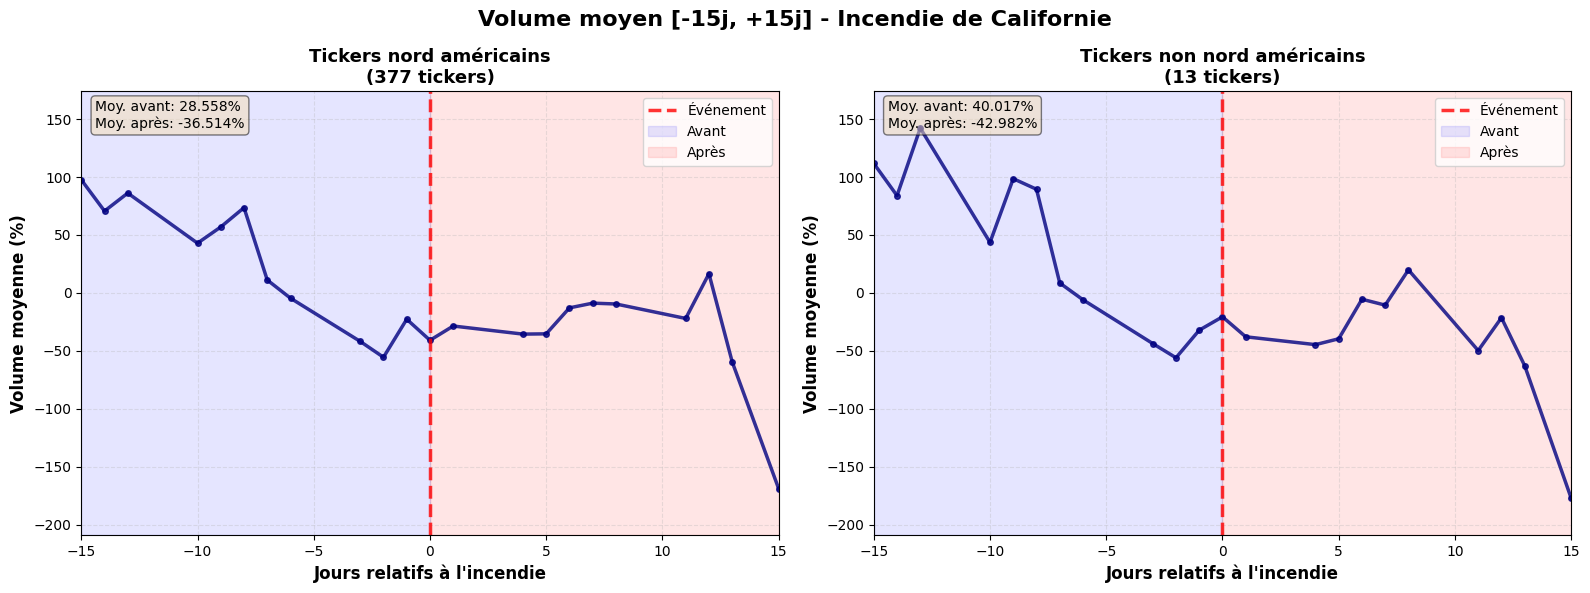

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Stocker les valeurs min/max pour synchroniser les échelles
all_values = []

# Calculer les rendements quotidiens moyens pour chaque groupe
for idx, (df_subset, label, ax) in enumerate([
    (df_na, 'Tickers nord américains', axes[0]),
    (df_non_na, 'Tickers non nord américains', axes[1])
]):
    # Grouper par date et calculer la moyenne des rendements
    daily_avg_volume = df_subset.groupby('Date')['volume_zscore'].mean() * 100
    
    # Stocker les valeurs pour calculer l'échelle globale
    all_values.extend(daily_avg_volume.values)
    
    # Créer un index de jours relatifs à l'événement
    dates = daily_avg_volume.index.sort_values()
    days_relative = [(d - date_event).days for d in dates]
    
    # Tracer la courbe
    ax.plot(days_relative, daily_avg_volume.loc[dates].values, 
        linewidth=2.5, color='navy', marker='o', markersize=4, alpha=0.8)
    
    # Ligne verticale pour l'événement
    ax.axvline(x=0, color='red', linestyle='--', linewidth=2.5, 
            label='Événement', alpha=0.8)
    
    # Ligne horizontale à 0 (retirée car volume ne peut être négative)
    # ax.axhline(y=0, color='gray', linestyle='-', linewidth=0.8, alpha=0.5)
    
    # Zones avant/après colorées
    ax.axvspan(-15, 0, alpha=0.1, color='blue', label='Avant')
    ax.axvspan(0, 15, alpha=0.1, color='red', label='Après')
    
    # Labels et titre
    ax.set_xlabel('Jours relatifs à l\'incendie', fontsize=12, fontweight='bold')
    ax.set_ylabel('Volume moyenne (%)', fontsize=12, fontweight='bold')
    ax.set_title(f'{label}\n({len(df_subset["Ticker"].unique())} tickers)', 
                fontsize=13, fontweight='bold')
    
    # Grille et légende
    ax.grid(True, alpha=0.3, linestyle='--')
    ax.legend(loc='best', fontsize=10)
    
    # Limites de l'axe X
    ax.set_xlim(-15, 15)
    
    # Ajouter les statistiques sur le graphique
    mean_before = df_subset[df_subset['Date'] < date_event]['volume_zscore'].mean() * 100
    mean_after = df_subset[df_subset['Date'] > date_event]['volume_zscore'].mean() * 100
    
    stats_text = f'Moy. avant: {mean_before:.3f}%\nMoy. après: {mean_after:.3f}%'
    ax.text(0.02, 0.98, stats_text, transform=ax.transAxes,
        fontsize=10, verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# === SYNCHRONISER L'ÉCHELLE Y DES DEUX GRAPHIQUES ===
# Calculer les limites communes
y_min = min(all_values)
y_max = max(all_values)
y_margin = (y_max - y_min) * 0.1  # Ajouter 10% de marge

# Appliquer la même échelle aux deux graphiques
for ax in axes:
    ax.set_ylim(y_min - y_margin, y_max + y_margin)

# Titre général
fig.suptitle(f'Volume moyen [-15j, +15j] - Incendie de Californie',
            fontsize=16, fontweight='bold', y=0.98)

plt.tight_layout()

II. Scandale des opioïdes

1. Returns

2. Volatilité

3. Volume

III. Tweet “Funding secured” d’Elon Musk

1. Returns

2. Volatilité

3. Volume

IV. Invasion de l’Ukraine par la Russie

1. Returns

2. Volatilité

3. Volume

V. Brexit

1. Returns

2. Volatilité

3. Volume